<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/puneet/gender_classification_2D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
df_male= pd.read_csv('/gdrive/My Drive/Audio_files/Combined_Dataframes/gender_male.csv')

In [28]:
df_female= pd.read_csv('/gdrive/My Drive/Audio_files/Combined_Dataframes/gender_female.csv')

In [5]:
print(df_male.shape, df_female.shape)

(30780, 219) (42174, 219)


In [6]:
gender_male=np.load('/gdrive/My Drive/Audio_files/Combined_Dataframes/male_2d_aug.npy')

In [7]:
gender_female=np.load('/gdrive/My Drive/Audio_files/Combined_Dataframes/female_2d_aug.npy')

In [8]:
print(gender_male.shape, gender_female.shape)

(30780, 30, 216, 1) (42174, 30, 216, 1)


In [8]:
#converting class into boolean
#male=1
for i in range(0,df_male.shape[0]):
  if df_male['labels'][i]=='male':
    df_male['labels'][i]=1;
    
#female=2
for i in range(0,df_female.shape[0]):
  if df_female['labels'][i]=='female':
    df_female['labels'][i]=2;

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
result=np.concatenate((gender_male,gender_female),axis=0)

In [10]:
del gender_male, gender_female

In [1]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

     |████████████████████████████████| 788kB 3.4MB/s 
     |████████████████████████████████| 358kB 12.2MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
     |████████████████████████████████| 122kB 3.5MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.


In [29]:
frames=[df_male,df_female];
df_label=pd.concat(frames);

In [12]:
del df_male, df_female

In [13]:
print(result.shape,df_label.shape)

(72954, 30, 216, 1) (72954, 219)


In [14]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(result
                                                    , df_label.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

In [15]:
del result, df_label

In [16]:
# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [17]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [18]:
nclass = 2
inp = Input(shape=(30,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
x = Convolution2D(64, (4,10), padding="same")(inp)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)
    
x = Convolution2D(64, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)
    
x = Convolution2D(64, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)
    
x = Convolution2D(64, (4,10), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)
x = Dropout(rate=0.2)(x)
    
x = Flatten()(x)
x = Dense(128)(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.2)(x)

x = Dense(128)(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.2)(x)

x = Dense(128)(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(rate=0.2)(x)
    
out = Dense(nclass, activation=softmax)(x)
model = models.Model(inputs=inp, outputs=out)
    
opt = optimizers.Adam(0.001, amsgrad=True)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])

In [20]:
import random
random.seed(1)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=25, verbose = 1, epochs=10, use_multiprocessing=True )

Train on 58363 samples, validate on 14591 samples
Epoch 1/10
58363/58363 [==============================] - 70s 1ms/step - loss: 0.0738 - acc: 0.9732 - val_loss: 0.0499 - val_acc: 0.9834
Epoch 2/10
58363/58363 [==============================] - 69s 1ms/step - loss: 0.0590 - acc: 0.9792 - val_loss: 0.0484 - val_acc: 0.9834
Epoch 3/10
58363/58363 [==============================] - 69s 1ms/step - loss: 0.0515 - acc: 0.9823 - val_loss: 0.0447 - val_acc: 0.9867
Epoch 4/10
58363/58363 [==============================] - 68s 1ms/step - loss: 0.0440 - acc: 0.9846 - val_loss: 0.0383 - val_acc: 0.9853
Epoch 5/10
58363/58363 [==============================] - 69s 1ms/step - loss: 0.0357 - acc: 0.9871 - val_loss: 0.0403 - val_acc: 0.9867
Epoch 6/10
58363/58363 [==============================] - 70s 1ms/step - loss: 0.0315 - acc: 0.9889 - val_loss: 0.0375 - val_acc: 0.9866
Epoch 7/10
58363/58363 [==============================] - 70s 1ms/step - loss: 0.0284 - acc: 0.9898 - val_loss: 0.0528 - val_acc

In [21]:
cd /gdrive/My Drive/Audio_files/

/gdrive/My Drive/Audio_files


In [22]:
# Save model and weights
model_name = 'gender_cnn2d_9901.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("/gdrive/My Drive/Audio_files/saved_models/gender_cnn2d_9901.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /gdrive/My Drive/Audio_files/saved_models/gender_cnn2d_9901.h5 


In [23]:
# loading json and model architecture 
json_file = open('/gdrive/My Drive/Audio_files/saved_models/gender_cnn2d_9901.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/gender_cnn2d_9901.h5")
print("Loaded model from disk")

Loaded model from disk


In [24]:
class get_results:
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
  
        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.'''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

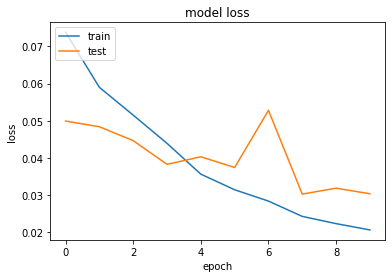

accuracy: 99.01%


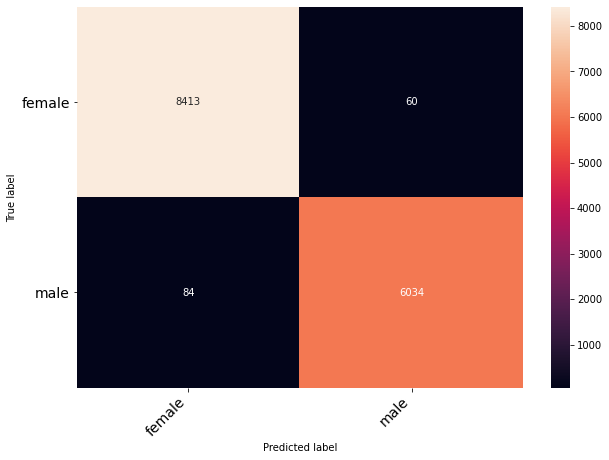

In [30]:
results = get_results(model_history,model,X_test,y_test, df_label.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, df_label.labels.unique(), model)